# **Deep keras CNN as digit-recognizer : complete tutorial**

### Hi kagglers 👋👋👋

### In this notebook, I'll show you how to build a deep convolutionnal neural network. We'll then train this CNN on the MNIST dataset to turn it into an incredibly effective digit-recognizer with a near 100% accuracy !

![](http://petr-marek.com/wp-content/uploads/2017/07/mnist.png)

### In this notebook, we are going to predict which number is drawn on images. By doing this, we will go through several topics and fundamental techniques of deep learning. Here is a list of these techniques and some additional resources that you can consult to find out more:¶

[*Overfitting*](https://elitedatascience.com/overfitting-in-machine-learning)   
[*Artificial neural networks*](https://www.superdatascience.com/blogs/the-ultimate-guide-to-artificial-neural-networks-ann)  
[*Convolutionnal neural networks*](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)  
[*Activation functions in neural networks*](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)  
[*Deep Learning with Python*](https://www.manning.com/books/deep-learning-with-python)

## **Table of Contents**

1. [**Data exploration & preparation**](#data_exploration)
2. [**CNN Theory**](#theory)
3. [**Building model with Keras**](#model)
4. [**Make prediction**](#prediction)

## **Imports and useful functions**

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#path of datasets
path_train = './datasets/train.csv'
path_test = './datasets/test.csv'

## **1. Data exploration** <a id="data_exploration"></a>

### Let's begin by printing a preview of the dataset and look at its size and what it contains:

In [3]:
#create dataframe for training dataset and print 5 first rows as preview
train_df_raw = pd.read_csv(path_train)
train_df_raw.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# print infos about the dataset
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
train_df_raw.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,...,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,...,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [6]:
# Check if there are missing datas
train_df_raw.isnull().values.any()
train_df_raw.isna().values.any()

False

### From this first preview and according to information from kaggle, it seems that each image contains 784 pixels (28x28 pixels), each pixel contain a value between 0 and 254 reprensenting the gray level of this pixel. There is no missing values. Let's try to display the first images from the values of the dataset:

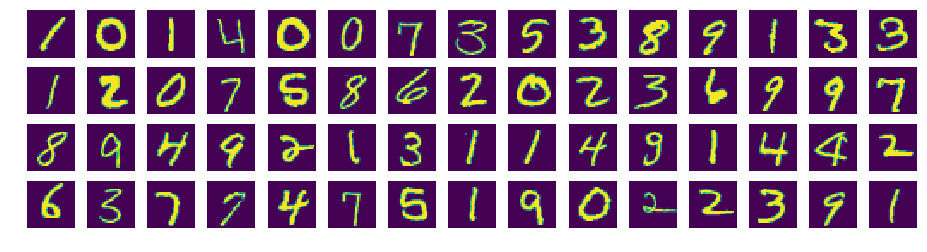

In [7]:
def dislay_images_from_pixels(nb): 
    images = [np.array(train_df_raw.drop(['label'], 1).iloc[i].tolist()).reshape(28, 28) for i in range (nb)]
    rows = int(nb/15) if int(nb/15) != 0 else int(nb/15) + 1
    plt.figure(figsize=(16, rows))
    for n in range(1, nb + 1):
        plt.subplot(rows, 15, n)
        plt.imshow(images[n-1])
        plt.axis('off')
        
dislay_images_from_pixels(60)

### Finally, let's check at the occurence of each class, to be sure that there is no asymmetry in our data that can skew the algorithm :

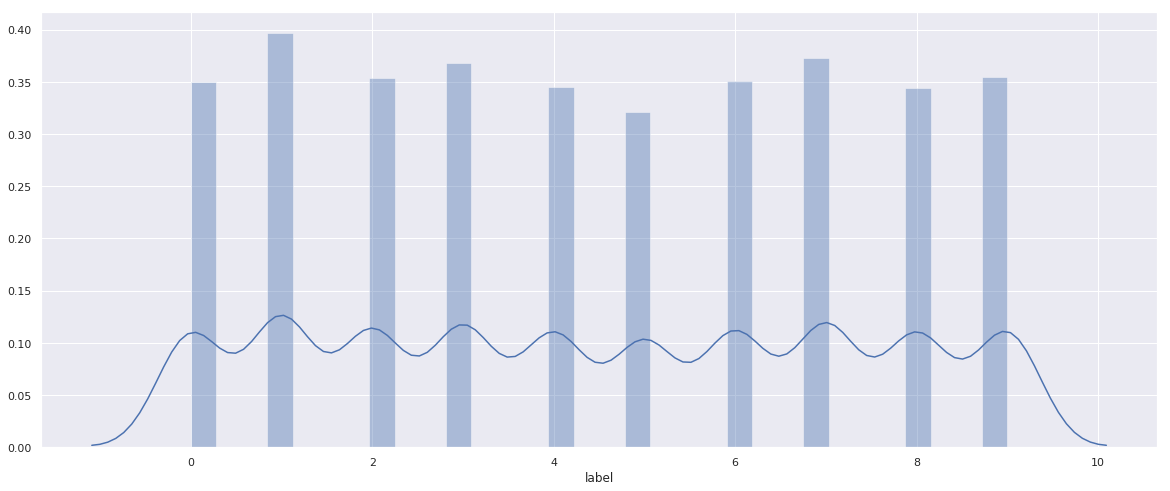

In [8]:
sns.set()
plt.figure(figsize=(20, 8))
sns.distplot(train_df_raw.label)
plt.show()

### Nice, the distribution of the labels seems to be sufficiently uniform to solve properly the multiclass classification problem. 
### Now, we have to prepare our data in order to pass it to the CNN. This preparation involves reshaping and normalize our observations since the CNN needs a 4D tensor. Normalizing the data is necessary when working with neural networks because feeding a NN with large or heterogeneous values can trigger large gradient updates that will prevent the network from converging. Finally, we need to hot-one encode the target, to make it match with the shape of the output of out CNN, which is a 10 length vector for a 10-class classification problem.

In [9]:
# Prepare data in order to pass it to a CNN
train_df = train_df_raw.copy()

# Separate target from images
X_train = train_df.drop(['label'], 1)
Y_train = train_df['label']

# Add 2 dimensions to pass a 4D tensor to the CNN and normalize values
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255 
# One-hot encoding of target
Y_train = np_utils.to_categorical(Y_train, 10)

## **2. CNN Theory** <a id="theory"></a>

### We are going to build a convolutionnal neural network. A CNN is a neural network componed of two parts : features learning and classification. The first part is basicaly applying several operations on images before passing the result to a standard ANN performing the second part. These operations contained in the features learning are convolution, application of an activation function, pooling (which we'll not use in this architecture), and flattening. Convolution + activation function and pooling may be repeated several times to build deeper networks and improve performances.
### Convolution is used to detect features in the images to make it more recognizable, it creates features maps containing the important features of the images. The activation function will then be applied on the features maps to break linearity of the images and make features even more recognizable. Pooling is used to downsize the result and make cnn faster. Flattening will transform the feature maps matrix from the convolution operation into a 1D vector to pass it to a standard ANN.
### Here is a standard architecture of a CNN, we can see that if is just a succession of convolution + activation function operations (here the function used is a relu, i.e. rectifier function) before an artificial neural network:

![](https://cdn-images-1.medium.com/max/2400/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

### Here is a convolutionnal neural network detailled when applied to the digit recognition task. Our model will be deeper (with more convolutionnal layers) and will not contain pooling steps but will basically be built on the same architecture :

![](https://cdn-images-1.medium.com/max/1600/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

## **3. Building model with Keras** <a id="model"></a>

### Now, let's implement our model ! We'll use Keras, a framefork seving as high level API for tensorflow, which is a tensor-manipulation framework made by google. Keras allows you to build neural networks by assembling blocks (which are the layers of our neural network). For more details, [here](https://elitedatascience.com/keras-tutorial-deep-learning-in-python) is a great keras tutorial.

![](https://cdn.actuia.com/wp-content/uploads/2018/05/keras.png)

In [10]:
def build_cnn():
    
    model = Sequential()
    
    # Multiple convolution operations to detect features in the images
    model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=3,activation='relu')) # no need to specify shape as there is a layer before
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4)) # reduce overfitting

    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4)) # reduce overfitting
    
    # Flattening and classification by standard ANN
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

### Now, let's explain the above keras model and try to link it to the representation of a convolutionnal neural network studied before. In the convolutionnal neural network architecture implemented above, we can observe several types of blocks :

- Convolutionnal layers :
        
      model.add(Conv2D(32,kernel_size=3,activation='relu'))
        
### These layers **only** performs the two first steps seen above (convolution and applying activation function). It first applies convolution on the images to detect features and create features maps. Then, it applies a relu activation function on the result of the convolution to supress linearity in the image to improve features detection. After this step (repeated several times to improve features detection), we are technically ready for passing the result to flattening and to the simple artificial neural network !  
        
- Batch normalization  :

      model.add(BatchNormalization())
        
### The batch normalisation is here to normalize the data after it goes out the convolutionnal layer, helping gradient propagation and allowing to build deeper models by stacking convolutional layers.
        
- Dropout

      model.add(Dropout(0.4))
        
### Dropout disables a fraction of all neurons of the previous densely connected or convolutionnal layer to reduce overfitting.
        
- Flattening
 
      model.add(Flatten())
         
### This just proceed the flattening operation we've seen before, in order to pass the features maps resulting of convolution operation to the standard artificial neural network.

![](https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/73_blog_image_1.png)
         
- Fully connected layer

      model.add(Dense(128, activation='relu'))

### This layer (called fully connected layer) is the main component of the ANN which will classify each digit to it's belonging class (i.e. the digit recognized). The softmax activation function is used in the output layer to convert output from 10 output nodes in probabilities of each digit to belong in each class.

### Do not hesitate to print a summary of the model to check the total number of parameter which gives you a overview of the depth and the complexity of your model (see below). We can clearly see here that flattening transforms a 3D tensor into a 1D tensor (or 4D into 2D).

In [11]:
build_cnn().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
__________

### These explanations are absolutely not complete at all and there is so much to say about neural networks that it is impossible to cover it in a notebook. To understand better these architecture and dive deeply (that's the case to say !)  in this exciting field, I highly recommend you to read the great book [**Deep Learning with Python**](https://www.manning.com/books/deep-learning-with-python) written by François Chollet, the creator of the keras framework. An other great ressource is accessible at the beginning of the notebook (convolutionnal neural networks) and may allows you to really understand how the features learning part works in a detailled way.

### Finally, I encourage you to check [**this link**](http://scs.ryerson.ca/~aharley/vis/conv/flat.html) to vizualise all these operations in practice, applied to the MNIST dataset ! Just draw the number in the square on the left of your screen and look at the result and the prediction made by the CNN. You can observe what the features maps looks like after the convolutions operation, and what it looks like after the pooling and flattening.

## **4. Make prediction** <a id="prediction"></a>

In [12]:
X_test = pd.read_csv(path_test)
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

In [13]:
model = build_cnn()
model.fit(X_train, Y_train, batch_size=64, epochs=16)

Epoch 1/16
42000/42000 [==============================] - 148s 4ms/step - loss: 0.2559 - acc: 0.9206
Epoch 2/16
42000/42000 [==============================] - 144s 3ms/step - loss: 0.0764 - acc: 0.9763
Epoch 3/16
42000/42000 [==============================] - 145s 3ms/step - loss: 0.0598 - acc: 0.9817
Epoch 4/16
42000/42000 [==============================] - 145s 3ms/step - loss: 0.0455 - acc: 0.9861
Epoch 5/16
42000/42000 [==============================] - 144s 3ms/step - loss: 0.0443 - acc: 0.9859
Epoch 6/16
42000/42000 [==============================] - 144s 3ms/step - loss: 0.0402 - acc: 0.9874
Epoch 7/16
42000/42000 [==============================] - 144s 3ms/step - loss: 0.0355 - acc: 0.9891
Epoch 8/16
42000/42000 [==============================] - 144s 3ms/step - loss: 0.0326 - acc: 0.9902
Epoch 9/16
42000/42000 [==============================] - 144s 3ms/step - loss: 0.0297 - acc: 0.9909
Epoch 10/16
42000/42000 [==============================] - 146s 3ms/step - loss: 0.0295 - a

In [14]:
prediction = model.predict_classes(X_test, verbose=0)
submission = pd.DataFrame({"ImageId": list(range(1,len(prediction)+1)),
                         "Label": prediction})
submission.to_csv("submission.csv", index=False, header=True)